# Chapter 12 時間や空間を扱うモデル

時系列データを解析するにあたり、応用範囲が広く、解釈がしやすく、拡張性が高い「状態空間モデル」を扱う。特に日次の売り上げデータのように、時が離散的で等間隔なデータの場合に使いやすい。

## 12.1 状態空間モデルことはじめ

時系列データの例

![Alt text](chap12/output/fig12-1-left.png)
![Alt text](chap12/output/fig12-1-center.png)
![Alt text](chap12/output/fig12-1-right.png)

図12.1

- 図 12.1(左): ガスコンロで熱した時間と水温の関係
  時間と与える熱量がほぼ比例し、与える熱量と温度が物理法則に従ってほぼ比例するので、単純に直線をあてはめてよさそうだ。

- 図 12.1(中): 薬剤の投与からの経過時間と薬の血中濃度の関係。
  背後に微分方程式に従う物理法則があると考えられるので、その法則から理論的に出された曲線(図中の灰色の太線)をあてはめることができる([7.3節参照](./chap07.ipynb#73-非線形の関係))。

- 図 12.1(右): 日付とイベントの来場人数(単位: 千人)の関係(直近21日分)
  他の二つのデータより規則性が見つけづらい(どのような曲線を「真の状態」として当てはめればよいかわからない)。しかし、以下の関係性が考えられる。
  - ある時刻の「真の状態」は一つ前の時刻の「真の状態」に似ている
  - 時刻と「真の状態」の関係式に確率的な変動がある。すなわち、時刻とともに「真の状態」が確率的に変化していく
  
  こうすると他の二つのデータの場合と同様に、状態の変化と観測を分けて考えることができる(図12.2).

![図12.2](chap12/output/fig12-2.png)
図12.2 状態空間モデル(1階差分のトレンド項(後述))のグラフィカルモデル。ここでTは時点の数、$[t]$はそのインデックスを表す。「真の状態」$\mu[t]$の変化と、観測値$Y[t]$の観測を分けて考える

1. 直接知ることができない「真の状態」の変化と観測を分けて考えるモデル: 状態空間モデル(state space model)

2. 「真の状態」の変化を表す式: システムモデル(System model), 状態方程式(state equation)

3. 観測を表す式: 観測モデル(observation model), 観測方程式(observation equation)

21:09:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:09:04 - cmdstanpy - INFO - CmdStan done processing.
21:09:04 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 2 divergent transitions (0.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


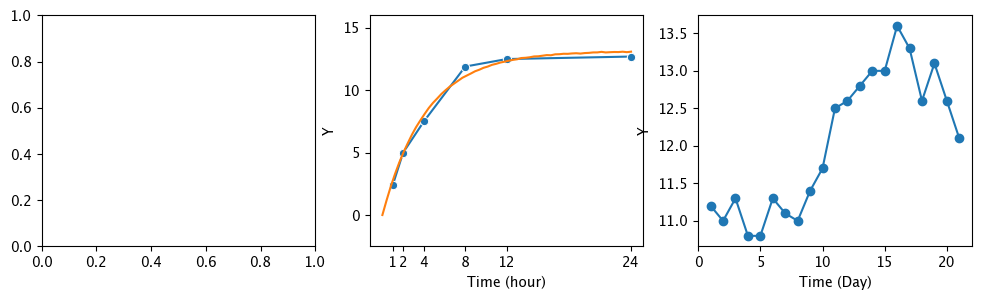

In [10]:
import numpy as np
import polars as pl
import seaborn as sns
from cmdstanpy import CmdStanModel
from matplotlib import pyplot as plt

_, axes = plt.subplots(1, 3, figsize=(12, 3))
"""図12.1(左)"""
# データが無いため省略
"""図12.1(中)"""
conc = pl.read_csv("chap07/input/data-conc.txt")

T_new = 60
Time_new = np.linspace(-0, 24, T_new)
data = {
    "T": conc.shape[0],
    "Time": conc["Time"].to_list(),
    "Y": conc["Y"].to_list(),
    "T_new": T_new,
    "Time_new": Time_new,
}
sm = CmdStanModel(
    stan_file="chap07/model/model7-4.stan",
    cpp_options={"STAN_THREADS": "TRUE"},
)
fit = sm.sample(data=data, seed=123)
test = pl.DataFrame(np.median(fit.y_new, axis=0), schema=["y_new"]).with_columns(
    pl.lit(Time_new).alias("Time_new"),
)

# 図の描画

sns.lineplot(conc, x="Time", y="Y", marker="o", ax=axes[1])
sns.scatterplot(conc, x="Time", y="Y", ax=axes[1])
sns.lineplot(
    test,
    x="Time_new",
    y="y_new",
    ax=axes[1],
)

plt.setp(
    axes[1],
    xlabel="Time (hour)",
    ylabel="Y",
    xticks=conc["Time"],
    yticks=np.arange(0, 16, 5),
    ylim=(-2.5, 16),
)

"""図12.1(右)"""
ss1 = pl.read_csv("./chap12/input/data-ss1.txt")
axes[2].plot("X", "Y", "o-", data=ss1)
plt.setp(axes[2], xlabel="Time (Day)", ylabel="Y")
plt.show()

### 12.1.1 解析の目的

目的
- 何日か先までの来場人数の真値を知りたい、予測したい(3日先まで)
- 変動の大きさと観測ノイズの大きさを知りたい
- 発表資料に載せたい図は1～21日目と3日先までの「真の状態」の80％ベイズ情頼区間とデータを重ねた図とする

### 12.1.2 データの分布の確認

時系列データで主に使われるグラフの形式
- 横軸に時刻・縦軸に値をとった折れ線グラフ (上記 図12.2(右)描画のpythonコードを参照)
- 横軸にラグ・縦動に標本自己共分散関数をとった折れ線グラフも使われることがある
  
  - 標本自己共分散関数: $\frac{1}{T} \sum_{t=k+1}^T (Y[t] - \overline{Y}) (Y[t-k] - \overline{Y})$
    
    (データの平均値が$\overline{Y} = \frac{1}{T} \sum_{t=1}^T Y[t]$、ラグが$k$のとき)
  
  - Rでは、acf関数やccf関数を使用
  - Pythonでは、statsmodels.tsa.stattools内のacf関数や、ccf関数
  - acf(自己共分散 autocorrelation function). ccf(相互関連関数 cross-covariance function)
    
このような時系列データ特有の可視化については[31] (北川源四郎.(2005).時系列解析入門.岩波書店.)を参照。

### 12.1.3 メカニズムの想像

[12.1節](#121-状態空間モデルことはじめ)で考えたシステムモデルでは、時点$t$の値$\mu[t]$は一つ前の時点の値$\mu[t -1]$と似ているとしたので、$\mu[t] - \mu[t -1]$は、小さい値$\varepsilon_{\mu}[t]$となるだろうといえる。(この$\mu[t]$を**1階差分のトレンド項**と呼ぶことがある)

上記の仮定を数式で表現する方法はいくつかある。
ここでは$\mu[t] - \mu[t-1]$が、平均0・標準偏差$\sigma_{\mu}$の正規分布に従うと考えると以下の式になる。
$$
\mu[t] - \mu[t-1] = \varepsilon_{\mu}[t] \qquad \varepsilon_{\mu}[t] \sim \mathrm{Normal}(0, \sigma_{\mu})
$$
この式は以下のように表現することもできる。
$$
\mu[t] = \mu[t-1] + \varepsilon_{\mu}[t] \qquad \varepsilon_{\mu}[t] \sim \mathrm{Normal}(0, \sigma_{\mu})
$$

すなわち、一つ前の時点の値$\mu[t-1]$に平均0・標準偏差$\sigma_{\mu}$の正規分布に従う確率的な変動が加わって$\mu[t]$になると考えることと等価。

一方、観測モデルでは、1日に平均0・標準偏差の$\sigma_y$の正規分布に従う観測ノイズが加わって$Y[t]$になると考える。

なお、このデータは来場人数なので厳密には非負数値をとるが、ここでは単位が大きくほぼ連続値と見なせるので、正規分布を使って考えてよい([5.2.3項参照](./chap05.ipynb#523-メカニズムの想像))

### 12.1.4 モデル式の記述

モデル式12-1

$$
\begin{align}
\mu[t] &= \mu[t-1] + \varepsilon_{\mu}[t-1]& &t = 2,\ldots,T \nonumber \\
Y[t] &= \mu [t] + \varepsilon_Y[t]& &t = 1, \dots, T \nonumber \\
\varepsilon_{\mu}[t] &\sim \mathrm{Normal}(0, \sigma_{\mu})& &t = 1, \dots, T-1 \nonumber \\
\varepsilon_Y[t] &\sim \mathrm{Normal}(0, \sigma_Y)& &t = 1, \ldots, T \nonumber
\end{align}
$$

- T: 時点の数
- t: Tのインデックス
- $\mu[1]$: 特に情報がないので、その事前分布は無情報事前分布とする

このモデル式から$\varepsilon_{\mu}[t]$と$\varepsilon_Y[t]$を消去すると以下になる

モデル式12-2
$$
\begin{align}
\mu[t] &\sim \mathrm{Normal}(\mu[t-1], \sigma_{\mu})& &t = 2, \ldots, T \nonumber \\
Y[t] &\sim \mathrm{Normal}(\mu[t], \sigma_Y)& &t = 1, \ldots, T  \nonumber
\end{align}
$$

この章では基本的に後者のモデル式の記法を使う。

### 12.1.5 Stanで実装

モデル式12-2の実装例 [model12-2.stan](chap12/model/model12-2.stan)

generated_quantitiesブロック

```stan
19 vector[T+T_pred] mu_all;  //図を描く時に、過去のμ[t]と3日先までのμ[t]をまとめてmu_allという変数にしておくと楽
20 vector[T_pred] y_pred;
21 mu_all[1:T] = mu;  // Tまではmuをそのまま代入
22  for (t in 1:T_pred) {  // 3日先までの値を生成
23    mu_all[T+t] = normal_rng(mu_all[T+t-1], s_mu);  // システムモデルに則って生成
24    y_pred[t] = normal_rng(mu_all[T+t], s_Y);   // y_predも同様に生成
25  }

```

実行すると以下のコードになる。

In [78]:
import polars as pl
from cmdstanpy import CmdStanModel

"""モデル式12-2による推定"""
ss1 = pl.read_csv("./chap12/input/data-ss1.txt")

T = len(ss1)
T_pred = 3
data = {
    "T": T,
    "T_pred": T_pred,
    "Y": ss1["Y"].to_list(),
}

sm = CmdStanModel(stan_file="./chap12/model/model12-2.stan")
fit = sm.sample(data=data, iter_sampling=4000, thin=5, seed=1232)

14:44:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:44:49 - cmdstanpy - INFO - CmdStan done processing.


### 12.1.6 推定結果の解釈

推定して得られた一部のパラメータの中央値と80%ベイズ頼区間は以下となる。($\sigma_{\mu}, \sigma_Y$)

また、解析の目的で想定した図を書く(図12.3(左))

In [22]:
import numpy as np

"""s_muとs_Yの80%信頼区間(中央値、10%, 90%)"""
print(f"s_mu: {np.percentile(fit.s_mu, (50, 10, 90))}")  # noqa: T201
print(f"s_Y: {np.percentile(fit.s_Y, (50, 10, 90))}")  # noqa: T201

s_mu: [0.3892775 0.2965546 0.508574 ]
s_Y: [0.1263295  0.03657432 0.2546217 ]


14:45:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:45:42 - cmdstanpy - INFO - CmdStan done processing.


/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


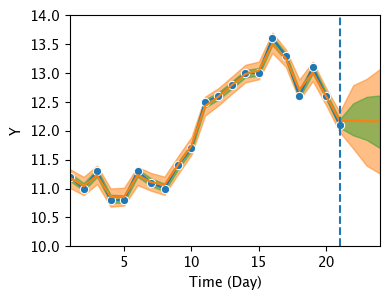

In [80]:
import arviz as az
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from cmdstanpy import CmdStanModel

"""モデル式12-2による推定(再)"""
ss1 = pl.read_csv("./chap12/input/data-ss1.txt")

T = len(ss1)
T_pred = 3
data = {
    "T": T,
    "T_pred": T_pred,
    "Y": ss1["Y"].to_list(),
}

sm = CmdStanModel(stan_file="./chap12/model/model12-2.stan")
fit = sm.sample(data=data, iter_sampling=4000, thin=5, seed=1232)

"""図12.3(左)"""
plt.figure(figsize=(4, 3))
ax = sns.lineplot(ss1, x="X", y="Y", marker="o")

mu_all_df = pl.DataFrame(fit.mu_all)
mu_all_mean_series = mu_all_df.transpose().mean_horizontal()
time_day = np.arange(1, mu_all_df.shape[1] + 1)

# 中央値.
sns.lineplot(
    x=time_day,
    y=mu_all_mean_series,
    ax=ax,
)
# 80%信頼区間.
az.plot_hdi(
    time_day,
    mu_all_df,
    hdi_prob=0.80,
    smooth=False,
    ax=ax,
)
# 50%信頼区間.
az.plot_hdi(
    time_day,
    mu_all_df,
    color="C2",
    hdi_prob=0.50,
    smooth=False,
    ax=ax,
)

ylim = (10, 14)
ax.vlines(T, ylim[0], ylim[1], linestyles="dashed")

plt.setp(ax, xlabel="Time (Day)", ylabel="Y", xlim=(1, 24), ylim=ylim)
plt.show()

### 12.1.7 状態の変化を滑らかにする

前節の図12.3(左)では以下の問題がある。
- 状態の変化がデコボコしていて滑らかでない
- 16日目から21日目にかけて入場人数が減少しているのに対し、22～24日目の予想は真横に伸びており直感と合わない。

これらは、モデル式12-2のシステムモデルが、直前の値だけに依存して正規分布で変化するモデルのためである。これに対応したのが以下のモデル。

モデル式12-3 (観測モデルはモデル式12-2と同じ)

$$
\begin{align}
\mu[t] - \mu[t-1] &= \mu[t-1] - \mu[t-2] + \varepsilon_{\mu}[t-2]& &t = 3, \ldots, T \nonumber \\
\varepsilon_{\mu}[t] &\sim \mathrm{Normal}(0, \sigma_{\mu})& &t = 1, \dots, T-2  \nonumber
\end{align}
$$

このシステムモデルでは、時点$t-2$から$t-1$、時点$t-1$から$t$への、状態の「変動幅」が似ているだろうと仮定している。ここから$(\mu[t] - \mu[t-1]) - (\mu[t-1] - \mu[t-2]) = \varepsilon_{\mu}[t]$が小さい値になると言える(このように差分を2段階で取るので、この項は**2階差分のトレンド項**と呼ぶことがある)。これによって状態の変化がデコボコであるという問題は解決できる。

モデル式12-1と同様初めの$\mu[1], \mu[2]$ｈについては特に情報がないため無情報事前分布を適用。

ここでモデル式12-3の1行目を$\mu[t]$について変形すると以下になる。
$$
\mu[t] = 2\mu[t-1] - \mu[t-2] + \varepsilon_{\mu}[t-2] \qquad t = 3, \ldots, T
$$

これを用いて、モデル式12-3から$\varepsilon_{\mu}[t]$を消去する。

モデル式12-4 (観測モデルはモデル式12-2と同じ)
$$
\mu[t] \sim \mathrm{Normal}( 2\mu[t-1] - \mu[t-2], \sigma_{\mu}) \qquad t = 3, \ldots, T
$$

実装例 [model12-4.stan](chap12/model/model12-4.stan)

変更点
```diff
 model {
-  mu[2:T] ~ normal(mu[1:(T-1)], s_mu);
+  mu[3:T] ~ normal(2*mu[2:(T-1)] - mu[1:(T-2)], s_mu);
   Y ~ normal(mu, s_Y);
 }
 
 generated quantities {
   vector[T+T_pred] mu_all;
   vector[T_pred] y_pred;
   mu_all[1:T] = mu;
   for (t in 1:T_pred) {
-    mu_all[T+t] = normal_rng(mu_all[T+t-1], s_mu);
+    mu_all[T+t] = normal_rng(2*mu_all[T+t-1] - mu_all[T+t-2], s_mu);
     y_pred[t] = normal_rng(mu_all[T+t], s_Y);
   }
 }
```

図12.3(左)と同様に図12.3(右)を描く

14:44:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:44:03 - cmdstanpy - INFO - CmdStan done processing.
14:44:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap12/model/model12-4.stan', line 14, column 2 to column 54)
Consider re-running with show_console=True if the above output is unclear!
14:44:04 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 3 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


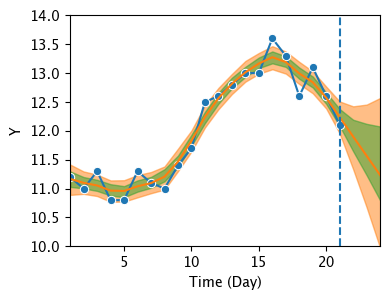

In [75]:
import arviz as az
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from cmdstanpy import CmdStanModel

"""モデル式12-4による推定"""
ss1 = pl.read_csv("./chap12/input/data-ss1.txt")

T = len(ss1)
T_pred = 3
data = {
    "T": T,
    "T_pred": T_pred,
    "Y": ss1["Y"].to_list(),
}

sm = CmdStanModel(stan_file="./chap12/model/model12-4.stan")
fit = sm.sample(data=data, iter_sampling=4000, thin=5, seed=1234)

"""図12.3(右)"""
mu_all_df = pl.DataFrame(fit.mu_all)
mu_all_mean_series = mu_all_df.transpose().mean_horizontal()
time_day = np.arange(1, mu_all_df.shape[1] + 1)

plt.figure(figsize=(4, 3))
# 元データの折れ線グラフ
ax = sns.lineplot(ss1, x="X", y="Y", marker="o")
# 中央値.
sns.lineplot(
    x=time_day,
    y=mu_all_mean_series,
    ax=ax,
)
# 80%信頼区間.
az.plot_hdi(
    time_day,
    mu_all_df,
    hdi_prob=0.80,
    smooth=False,
    ax=ax,
)
# 50%信頼区間.
az.plot_hdi(
    time_day,
    mu_all_df,
    color="C2",
    hdi_prob=0.50,
    smooth=False,
    ax=ax,
)

ylim = (10, 14)
ax.vlines(T, ylim[0], ylim[1], linestyles="dashed")

plt.setp(ax, xlabel="Time (Day)", ylabel="Y", xlim=(1, 24), ylim=ylim)
plt.show()

## 12.2 季節調整項

「季節もの」の四半期ごとの販売数(単位: 千個)の時系列データがあるとする([data-ss2.txt](chap12/input/data-ss2.txt))。

グラフを描くと図12.4(左)となり、季節に合わせた周期性が確認できる。これまで扱ってきた状態空間モデルを季節調整項を入れて拡張する。

![Alt text](chap12/output/fig12-4-left.png)
図12.4(左)

### 12.2.1 メカニズムの想像

このような時系列データでは、観測値$Y[t]$を要素の和に分解するのが定石。以下の要素で分解する。

$$
Y[t] = \mu[t] + season[t] + \varepsilon_Y[t]
$$

- トレンド項$\mu[t]$: 1階差分を用いる
- 季節調整項$season[t]$: 周期$L$の周期性を持つ(ここでは$L=4$)
- 観測ノイズ$\varepsilon_Y[t]$
- $\varepsilon_{season}[t]$: 任意の連続した$L$個の$season[t], season[t-1], \ldots, season[t-(L-1)]$の和。常に小さいになると考える。
- 季節調整項の1年分の合計は、季節によって売上にばらつきがあるにせよ、その影響はキャンセルして小さい値になるだろうと考える。

ここではこれらの仮定を、$\sum_{l=0}^{L-1} season[t-l]$は平均$0$・標準偏差$\sigma_{season}$の正規分布に従うと考えて数式化する。

$$
\sum_{l=0}^{L-1} season[t-l] = \varepsilon_{season}[t] \qquad \varepsilon_{season}[t] \sim \mathrm{Normal}(0, \sigma_{season})
$$

この式は以下のようにも表現できる
$$
season[t] = -\sum_{l=1}^{L-1} season[t-l] + \varepsilon_{season}[t] \qquad \varepsilon_{season}[t] \sim \mathrm{Normal}(0, \sigma_{season})
$$

この式から、$-\sum_{l=1}^{L-1}season[t-l]$に平均$0$・標準偏差$\sigma_{\mu}$の正規分布に従う確率的な変動が加わって$season[t]$になると解釈できる。

### 12.2.2 モデルの記述

モデル式12-5

$$
\begin{align}
\mu[t] &= \mu[t - 1] + \varepsilon_{\mu}[t - 1]& &t = 2, \ldots, T \nonumber \\
season[t] &= -\sum_{l = 1}^{L - 1} season[t - l] + \varepsilon_{season}[t - 3]& &t = 4, \ldots, T \nonumber \\
Y[t] &= \mu[t] + season[t] + \varepsilon_Y[t]& &t = 1, \ldots, T \nonumber \\
\varepsilon_{\mu}[t] &\sim \mathrm{Normal}(0,\sigma_{\mu})& &t = 1, \ldots, T - 1 \nonumber \\
\varepsilon_{season}[t] &\sim \mathrm{Normal}(0, \sigma_{season})& &t = 1, \ldots, T - 3 \nonumber \\
\varepsilon_Y[t] &\sim \mathrm{Normal}(0, \sigma_Y)& &t=1, \dots, T
\end{align} \nonumber
$$

ここで$\mu[1]$と$season[t]\ (t = 1, 2, 3)$については情報がないので、無情報事前分布を設定する。このモデル式から$\varepsilon_{\mu}[t], \varepsilon_{season}[t], \varepsilon_Y[t]$を消去してモデル式を変形する。

モデル式12-6

$$
\begin{align}
\mu[t] &\sim \mathrm{Normal}(\mu[t - 1],\sigma_{\mu})& &t = 2, \ldots, T \nonumber \\
season[t] &\sim \mathrm{Normal}(-\sum_{l = 1}^{L - 1} season[t - l], \sigma_{season})& &t = 4, \ldots, T \nonumber \\
Y[t] &\sim \mathrm{Normal}(\mu[t] + season[t], \sigma_Y)& &t = 1, \ldots, T \nonumber
\end{align} \nonumber
$$

### 12.2.3 Stanで実装

モデル式12.6の実装例 [model12-6.stan](chap12/model/model12-6.stan)

```stan
19  model {
20    mu[2:T] ~ normal(mu[1:(T-1)], s_mu);
21    for(t in 4:T)
22      season[t] ~ normal(-sum(season[(t-3):(t-1)]), s_season);
23    Y ~ normal(y_mean, s_Y);
24  }
```
21~22行が季節調整項。ここの部分をベクトル化できる。具体的にはtransformed_parametersブロックで$\sum_{l = 0}^3 season[t - l]$を算出し、変数に格納する。

変更後 [model12-6b.stan](chap12/model/model12-6b.stan)
```diff
 transformed parameters {
   vector[T] y_mean;
   vector[T-3] sum_part_season;
   y_mean = mu + season;
+  for(t in 4:T)
+    sum_part_season[t-3] = sum(season[(t-3):t]);
 }

 model {
   mu[2:T] ~ normal(mu[1:(T-1)], s_mu);
-  for(t in 4:T)
-    season[t] ~ normal(-sum(season[(t-3):(t-1)]), s_season);
+   sum_part_season ~ normal(0, s_season);
   Y ~ normal(y_mean, s_Y);
 }
```

***以下の内容はcmdstanでは警告されなかった**

このmodel12-6b.stanをコンパイルすると以下の警告メッセージが出力される。
```text
DIAGNOSTIC(S) FROM PARSER:
Warning (non-fatal):
Left-hand side of sampling statement (~) may contain a non-linear transform of a parameter or local variable.
If so, you need to call increment_log prob() with the log absolute determinant of the Jacobian of the transform.
Left-hand-side of sampling statement:
    sum_part_season ~ normal (...)
```

これは「～」の左辺にパラメータの非線形の変数変換(sum_part_season)が含まれている場合、そのヤコビアンの絶対値の対数をlp__に加える必要がある、という意味である。
しかし、ヤコビアンが定数であると把握している場合や、式を変形した等価のモデルでは警告が出ないことが分かっている場合には特に気にしなくてよい。ここでは後者に該当するので(警告の出ないmodel12-6.stanの21~22行目と等価なので)気にする必要はない。ヤコビアンの調整については、Stanのマニュアルの「Reparameterization & Change of Variables」の章を参照。

### 12.2.4 推定結果の解釈

推定結果からベイズ信頼区間を描く(図12.4)。トレンド項と季節調整項が分離できていると言える。未来予測はこの章の練習問題で実施する。

17:15:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:15:16 - cmdstanpy - INFO - CmdStan done processing.
17:15:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap12/model/model12-6.stan', line 20, column 2 to column 38)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap12/model/model12-6.stan', line 22, column 4 to column 60)
Consider re-running with show_console=True if the above output is unclear!


17:15:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:15:20 - cmdstanpy - INFO - CmdStan done processing.
17:15:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap12/model/model12-6b.stan', line 23, column 2 to column 38)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap12/model/model12-6b.stan', line 24, column 2 to column 40)
Consider re-running with show_console=True if the above output is unclear!


/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_p

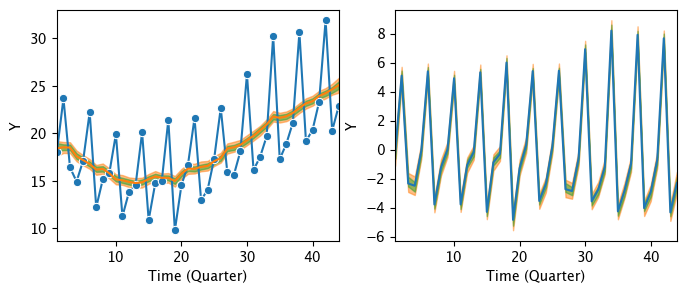

In [20]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from cmdstanpy import CmdStanModel
from matplotlib.axes import Axes

"""推定"""
ss2 = pl.read_csv("./chap12/input/data-ss2.txt")
data = {
    "T": len(ss2),
    "Y": ss2["Y"].to_list(),
}

# モデル式12-6
sm = CmdStanModel(stan_file="./chap12/model/model12-6.stan")
fit = sm.sample(data=data, iter_sampling=4000, thin=5, seed=1234)

# モデル式12-6b
sm_b = CmdStanModel(stan_file="./chap12/model/model12-6b.stan")
fit_b = sm_b.sample(data=data, iter_sampling=4000, thin=5, seed=1234)

"""図12.4"""


def draw_graph(
    mcmc_data: pl.DataFrame,
    mean: pl.Series,
    time: np.ndarray,
    ax: Axes,
) -> None:
    """信頼区間のグラフを描画."""
    # 中央値.
    sns.lineplot(x=time, y=mean, ax=ax)
    # 80%信頼区間.
    az.plot_hdi(time, mcmc_data, hdi_prob=0.80, smooth=False, ax=ax)
    # 50%信頼区間.
    az.plot_hdi(time, mcmc_data, color="C2", hdi_prob=0.50, smooth=False, ax=ax)


_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharex=True)

# 図12.4(左)

# トレンド項muのデータ
mu_df = pl.DataFrame(fit_b.mu)
mu_mean_series = mu_df.transpose().mean_horizontal()
# X軸(Time(Qarter)
time_quarter = np.arange(1, mu_df.shape[1] + 1)

# 元データの折れ線グラフ
sns.lineplot(ss2, x="X", y="Y", marker="o", ax=ax1)
# 信頼区間(中央値, 80%, 50%)
draw_graph(mu_df, mu_mean_series, time_quarter, ax1)
plt.setp(ax1, xlabel="Time (Quarter)", ylabel="Y", xlim=(1, 44))

# 図12.4(右)

# 季節調整項seasonのデータ
season_df = pl.DataFrame(fit_b.season)
season_mean_series = season_df.transpose().mean_horizontal()

# 信頼区間(中央値, 80%, 50%)
draw_graph(season_df, season_mean_series, time_quarter, ax2)
plt.setp(ax2, xlabel="Time (Quarter)", ylabel="Y", xlim=(1, 44))

plt.show()

## 12.3 変化点検出

これまでシステムモデル・観測モデルは正規分布に従うとしていたが、現象にあわせて他の分布も使える。例えば、観測モデルの$\varepsilon_Y[t]$にコーシー分布を使えば、[7.9節](./chap07.ipynb#79-外れ値)で説明したように外れ値の影響を軽減できる。

ここではシステムモデルの$\varepsilon_{\mu}[t]$にコーシー分布を使うことで変化点検出を行う([31]北川源四郎.(2005).時系列解析入門.岩波書店.の14.4節参照)。

コーシー分布は以下の性質を持っている。
- $\mathrm{Cauchy}(0, \sigma)$: ほとんどの場合は0の近くの値を生成するが、まれに非常に大きな値を生成する

この性質を状態の変化に応用すれば変化点検出ができる。以下の図12.5(左)の時系列データ(data-changepoint.txt)に対して変化点検出を行う。
![Afig12-5-left.png](chap12/output/fig12-5-left.png)

モデル式にすると以下になる.

モデル式12-7

$$
\begin{align}
\mu[t] &\sim \mathrm{Cauchy}(\mu[t-1], sigma_{\mu})& &t = 2, \ldots, T \nonumber \\
Y[t] &\sim \mathrm{Normal}(\mu [t], \sigma_Y)& &t = 1, \dots, T \nonumber
\end{align}
$$

モデル式12-2のシステムモデルの正規分布がコーシー分布に変わっただけだが、実装では[model12-2.stan](chap12/model/model12-2.stan)の14行目 mu[2:T]~ normal(mu[1:(T-1)], s_mu)のnormalをcauchyに変更しても推定がうまく行かない。これは[7.9節](./chap07.ipynb#79-外れ値)とは異なり、コーシー分布から生成した値を平均パラメータとして、再度コーシー分布から生成する状況では$\mu[t]$の推定が効率的にできないため。コーシー分布の幹と比べ、裾の長い部分では相対的にパラメータの更新幅が小さくなり、サンプリング候補の棄却が増えて効率的にサンプリングできないからだ。

![fig6-13.png](chap06/output/fig6-13.png)
図6.13 コーシー分布

そこで、[10.3節](./chap10.ipynb#103-再パラメータ化)で説明した再パラメータ化を行い、コーシー分布からスケールを分離する。
コーシー分布は累積分布関数の逆関数が簡単に求まるので、逆関数法を使う事ができる[<sup>1)</sup>](#fn1)。

$\mathrm{Cauchy}(y | \mu, \sigma)$の累積分布関数は、
$$
\mathrm{F}(y) = \frac{1}{\pi} \mathrm{arctan} \left( \frac{y - \mu}{\sigma} \right) + 0.5
$$
その逆関数は、
$$
\mathrm{F}^{-1}(x) = \mu + \sigma \tan (\pi (x - 0.5))
$$
となるので、$x$が$\mathrm{Uniform}(0, 1)$に従う時に$F^{-1}(x)$は$\mathrm{Cauchy}(\mu, \sigma)$に従う。

この変数変換を利用したモデル式12-7の実装例 [model12-7.stan](chap12/model/model12-7.stan)

推定結果は図12.7(右)となり、変化点が検出できた。

> [<sup>1)</sup>](#fn1-back) 逆関数法を使った乱数生成力法の説明は[23]\(杉山将.(2015).機械学習のための確率と続計講談社.)の6章や[英語のWikipedia](https://en.wikipedia.org/wiki/Inverse_transform_sampling)を参照のこと。

23:02:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:03:01 - cmdstanpy - INFO - CmdStan done processing.
23:03:01 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 divergent transitions (0.2%)
	Chain 2 had 1 divergent transitions (0.1%)
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 4 had 3 divergent transitions (0.3%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.12/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


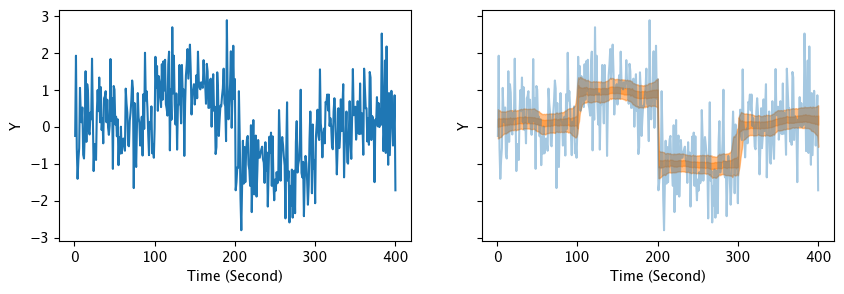

In [24]:
import arviz as az
import matplotlib.pyplot as plt
import polars as pl
from cmdstanpy import CmdStanModel

"""推定"""
changepoint = pl.read_csv("./chap12/input/data-changepoint.txt")

data = {
    "T": len(changepoint),
    "Y": changepoint["Y"].to_list(),
}
sm = CmdStanModel(stan_file="./chap12/model/model12-7.stan")
fit = sm.sample(data=data, seed=1234)

"""図12.5"""
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)

# 図12.5(左)
ax1.plot("X", "Y", data=changepoint)
plt.setp(ax1, xlabel="Time (Second)", ylabel="Y")

# 図12.5(右)
mu_df = pl.DataFrame(fit.mu)
time_second = changepoint["X"]

# 信頼区間
az.plot_hdi(time_second, mu_df, hdi_prob=0.95, smooth=False, ax=ax2)
az.plot_hdi(time_second, mu_df, hdi_prob=0.50, smooth=False, ax=ax2)

ax2.plot("X", "Y", data=changepoint, alpha=0.4)
plt.setp(ax2, xlabel="Time (Second)", ylabel="Y")

plt.show()

## 12.4 その他の拡張方法